## Install Libraries

In [1]:
import openseespy.opensees as ops 
import openseespy.postprocessing.ops_vis as opsv
import openseespy.postprocessing.Get_Rendering as opsplt
import math as math
from math import asin, sqrt
import numpy as np
import matplotlib.pyplot as plt

## Unit Definition

In [2]:
# =============================================================================
# Define Units
# =============================================================================

m = 1.0               # Meters
KN = 1.0              # KiloNewtons
N = 0.001*KN
sec = 1.0             # Seconds

mm = 0.001*m          # Milimeters
cm = 0.01*m           # Centimeters 
MPa = 1e3*(KN/m**2)   # Mega Pascal 
GPa = 1e6*(KN/m**2)   # Giga Pascal 

## Build Model - Reinforced Concrete Frame

In [3]:
# Clear memory of past model definitions
ops.wipe()

# Create ModelBuilder (with two-dimensions and 3 DOF/node)
ops.model('Basic', '-ndm', 2, '-ndf', 3)

# Structural frame
numBay = 1
numFloor = 3
bayWidth = 7.35*m
storyH = 3*m
storyHT = storyH*(numFloor)
storyHeights = [storyH]*numFloor # same height for all sotries

In [4]:
def getColumn():
    
    # =============================================================================
    # Materials
    # =============================================================================
    
    # Define concrete material
    f_c_1 = -25 * MPa          # f'c in compression for unconfined concrete
    f_c_2 = -28 * MPa          # f'c in compression for confined concrete
    eps_c = -0.002             # strain at maximum stress in compression 
    eps_u = -0.02              # strain at ultimate stress in compression
    f_y = 420.0 * MPa          # fy for reinforcing steel
    E_s = 210.0 * GPa          # E for reinforcing steel

    rebar = 0.25 * np.pi * (25 * mm) ** 2

    # Uniaxial Kent-Scott-Park concrete material with degraded linear unloading/reloading
    mat_KSP_unconf = {
        'ID': 'Concrete02',
        'matTag': 1,
        'fpc': f_c_1,
        'epsc0': eps_c,
        'fpcu': 0.2 * f_c_1,
        'epsU': eps_u,
        'lamda': 0.1,
        'ft': -0.1 * f_c_1,
        'Ets': (-0.1 * f_c_1) / 0.002
    }

    # Uniaxial Kent-Scott-Park concrete material with degraded linear unloading/reloading...confined
    mat_KSP_conf = {
        'ID': 'Concrete02',
        'matTag': 2,
        'fpc': f_c_2,
        'epsc0': eps_c,
        'fpcu': 0.2 * f_c_2,
        'epsU': eps_u,
        'lamda': 0.1,
        'ft': -0.1 * f_c_2,
        'Ets': (-0.1 * f_c_2) / 0.002
    }

    # Uniaxial Giuffre-Menegotto-Pinto steel with isotropic strain hardening
    mat_GMP = {
        'ID': 'Steel02',
        'matTag': 3,
        'Fy': f_y,
        'E0': E_s,
        'b': 0.005,
        'R0': 20.0,
        'cR1': 0.925,
        'cR2': 0.15
    }

    # Confined & unconfined concrete material 
    ops.uniaxialMaterial(*mat_KSP_unconf.values())
    ops.uniaxialMaterial(*mat_KSP_conf.values())
    
    # For reinforcing steel
    ops.uniaxialMaterial(*mat_GMP.values())

    # =============================================================================
    # Rebar Placing
    # =============================================================================
    
    h = 500 * mm  # height
    w = 500 * mm  # width 
    ct = 50 * mm  # cover thickness
    ar = h * w    # cross-sectional area
    dia = 24 * mm # rebar diameter
    Abar = np.pi * (dia / 2) ** 2  # rebar area
    numBar = 4  # number of rebars top/bottom
    numInt = 2  # number of rebars intermediate layers
    numBarS = int(numInt / 2)  # intermediate per side
    nfCoreY = 10
    nfCoreZ = 10
    nfCoverY = 10
    nfCoverZ = 10

    # Define Rebar vertices
    coverY = h / 2.0
    coverZ = w / 2.0
    coreY = coverY - ct
    coreZ = coverZ - ct
    IntYStart = -coreY + 2 * coreY / (numBarS + 1)  # Bottom (y-axis) coordinate for intermediate bars 
    IntYEnd = coreY - 2 * coreY / (numBarS + 1)  # Top (y-axis) coordinate for intermediate bars

    # =============================================================================
    # Test Sections
    # =============================================================================
    
    # Section('Fiber', secTag)
    ops.section('Fiber', 1)

    # Patch('quad', matTag, numSubdivIJ, numSubdivJK, *crdsI, *crdsJ, *crdsK, *crdsL)
    # Core patch
    ops.patch('quad', 2, nfCoreZ, nfCoreY, -coreY, coreZ, -coreY, -coreZ, coreY, -coreZ, coreY, coreZ)
    
    # Cover patch
    ops.patch('quad', 1, 2, nfCoverY, -coverY, coverZ, -coreY, coreZ, coreY, coreZ, coverY, coverZ)
    ops.patch('quad', 1, 2, nfCoverY, -coreY, -coreZ, -coverY, -coverZ, coverY, -coverZ, coreY, -coreZ)
    ops.patch('quad', 1, nfCoverZ, 2, -coverY, coverZ, -coverY, -coverZ, -coreY, -coreZ, -coreY, coreZ)
    ops.patch('quad', 1, nfCoverZ, 2, coreY, coreZ, coreY, -coreZ, coverY, -coverZ, coverY, coverZ)

    # Define reinforcing layers
    ops.layer('straight', 3, numBarS, Abar, IntYStart, coreZ, IntYEnd, coreZ)  # intermediate skin reinf. +z
    ops.layer('straight', 3, numBarS, Abar, IntYStart, -coreZ, IntYEnd, -coreZ)  # intermediate skin reinf. -z
    ops.layer('straight', 3, numBar, Abar, coreY, coreZ, coreY, -coreZ)  # top layer reinforcement
    ops.layer('straight', 3, numBar, Abar, -coreY, coreZ, -coreY, -coreZ)  # bottom layer reinforcement

    # GeomTransf('Linear', transfTag, *vecxz, '-jntOffset', *dI, *dJ)
    ops.geomTransf('PDelta', 1, [-1, 0, 0])  # column
    ops.geomTransf('Linear', 2, [0, 1, 0])   # beam

    # BeamIntegration('Lobatto', tag, secTag, N)
    ops.beamIntegration('Lobatto', 3, 1, 3)   # column
    ops.beamIntegration('Lobatto', 4, 1, 5)  # beam 

    # =============================================================================
    # Display Section
    # =============================================================================
    
    fiber_sec = [['section', 'Fiber', 1],
                     ['patch', 'quad', 2, nfCoreZ, nfCoreY, -coreY, coreZ, -coreY, -coreZ, coreY, -coreZ, coreY, coreZ],
                     ['patch', 'quad', 1, 2, nfCoverY, -coverY, coverZ, -coreY,   coreZ,   coreY,   coreZ,  coverY, coverZ],
                     ['patch', 'quad', 1, 2, nfCoverY, -coreY, -coreZ,  -coverY, -coverZ,  coverY, -coverZ, coreY,  -coreZ],
                     ['patch', 'quad', 1, nfCoverZ, 2, -coverY, coverZ, -coverY, -coverZ, -coreY,  -coreZ, -coreY,   coreZ],
                     ['patch', 'quad', 1, nfCoverZ, 2,  coreY,  coreZ,   coreY,  -coreZ,   coverY, -coverZ, coverY, coverZ],
                     ['layer', 'straight', 3 ,numBarS ,Abar, IntYStart,  coreZ,  IntYEnd,  coreZ],
                     ['layer', 'straight', 3 ,numBarS ,Abar, IntYStart,  -coreZ,  IntYEnd,  -coreZ],
                     ['layer', 'straight', 3 ,numBar ,Abar,  coreY,  coreZ,  coreY, -coreZ],
                     ['layer', 'straight', 3 ,numBar ,Abar, -coreY,  coreZ, -coreY, -coreZ]
                    ]

    matcolor = ['r', 'lightgrey', 'gold', 'w', 'w', 'w']
    opsv.plot_fiber_section(fiber_sec, matcolor=matcolor)
    plt.axis('equal')
    plt.show()

<IPython.core.display.Javascript object>


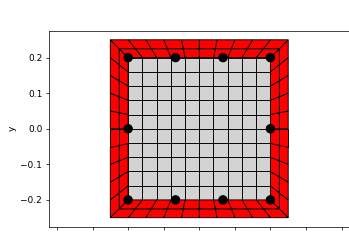

In [5]:
getColumn()

# =============================================================================
# Define Nodes
# =============================================================================

# Create nodes
nodeTag = 1

# Nodetag for Integration Points
yLoc = 0.
for j in range(0, numFloor + 1):

    xLoc = 0.
    for i in range(0, numBay + 1):
        ops.node(nodeTag, xLoc, yLoc)
        xLoc += bayWidth
        nodeTag += 1
    if j < numFloor:
        storyHeight = storyHeights[j]

    yLoc += storyHeight

# Assign Constraints
# (kj) number of row has to match the number of ground fix points
ops.fix(1, 1, 1, 1)
ops.fix(2, 1, 1, 1)

# =============================================================================
# Assign Column and Beam (element tag and material)
# =============================================================================

# Add column elements
eleTag = 1
for j in range(0, numBay + 1):
    end1 = j + 1
    end2 = end1 + numBay + 1
    #secType = beams[j - 1]
    for i in range(0, numFloor):
        # element('forceBeamColumn', eleTag, *eleNodes, transfTag, integrationTag, '-iter', maxIter=10, tol=1e-12)
        ops.element('forceBeamColumn', eleTag, *[end1, end2], 1, 3, '-iter', 10, 1e-12)
        end1 = end2
        end2 += numBay + 1
        eleTag += 1
        
# Add beam elements
# (kj) range starts from 1 = no floor on the ground
for j in range(1, numFloor + 1):
    end1 = (numBay + 1) * j + 1
    end2 = end1 + 1
    #secType = beams[j - 1]
    for i in range(0, numBay):
        # element('forceBeamColumn', eleTag, *eleNodes, transfTag, integrationTag, '-iter', maxIter=10, tol=1e-12)
        ops.element('forceBeamColumn', eleTag, *[end1, end2], 2, 4, '-iter', 10, 1e-12)
        end1 = end2
        end2 = end1 + 1
        eleTag += 1
    
# Rigid floor constraint & masses
# (kj) node that are next to each other, they move together, whereas node that are apart they are assigned a very small number
massX = 100
nodeTagR = 2 #nodeTagR +1
nodeTag = 1 #first floor node
for j in range(1, numFloor + 1):
    for i in range(0, numBay + 1):

        if nodeTag != nodeTagR:
            ops.equalDOF(nodeTagR, nodeTag, 1)
        else:
            ops.mass(nodeTagR, massX, 1.0e-10, 1.0e-10)

        nodeTag += 1

    nodeTagR += numBay + 1

<IPython.core.display.Javascript object>


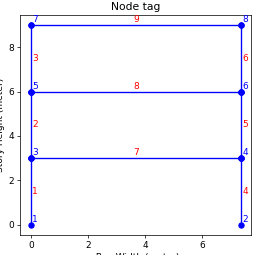

Text(0.5, 1.0, 'Node tag')

In [6]:
# =============================================================================
# Display Model Tag
# =============================================================================

opsv.plot_model(1, 1, fig_wi_he=(10,10))
plt.xlabel(' Bay Width (meter)')
plt.ylabel('Story Height (meter)')
plt.title('Node tag')

## Modal Analysis

No Model_ODB specified to plot modeshapes
2D model


Using DomainModalProperties - Developed by: Massimo Petracca, Guido Camata, ASDEA Software Technology
# MODAL ANALYSIS REPORT

* 1. DOMAIN SIZE:
# This is the size of the problem: 2 for 2D problems, 3 for 3D problems.
2


* 2. EIGENVALUE ANALYSIS:
#          MODE        LAMBDA         OMEGA     FREQUENCY        PERIOD
# ------------- ------------- ------------- ------------- -------------
              1       196.676       14.0241       2.23201      0.448026
              2       2722.51       52.1777       8.30434      0.120419
              3      3.49e+15   5.90762e+07   9.40227e+06   1.06357e-07


* 3. TOTAL MASS OF THE STRUCTURE:
# The total masses (translational and rotational) of the structure
# including the masses at fixed DOFs (if any).
#            MX            MY           RMZ
# ------------- ------------- -------------
            300             0          2475


* 4. TOTAL FREE MASS OF THE STRUCTURE:
# The total masses (translational and rotational) of the structure
# 

<IPython.core.display.Javascript object>


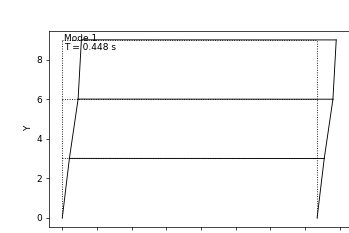

No Model_ODB specified to plot modeshapes
2D model


<IPython.core.display.Javascript object>


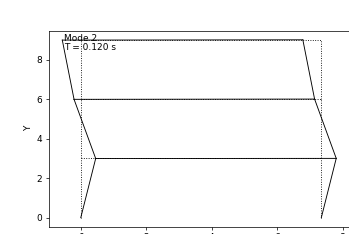

(<Figure size 432x288 with 1 Axes>, <AxesSubplot:xlabel='X', ylabel='Y'>)

In [7]:
# =============================================================================
#  Modal Analysis 
# =============================================================================

numEigen = numFloor
eigenValues = ops.eigen(numEigen) # eigenvalue analysis (for 2 modes)
ops.modalProperties("-print", "-file", "ModalReport.txt", "-unorm") # perform modal analysis, and print results

opsplt.plot_modeshape(1, 5) # 1st Mode Shape
opsplt.plot_modeshape(2, 5) # 2nd Mode Shape